# Housekeeping

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


Before running the next line, go to your iron code benders/HW1 and right click it and click add shortcut. This will allow for us to access the files within the HW1 folder within this notebook. 

In [ ]:
!ls "/content/drive/My Drive/HW1"

 csci5541s23_HW1.pdf		 HW1.ipynb		 test.csv
 data				 preprocessed_data	 train.csv
 dynasent-v1.1			'Report HW1.gdoc'	 valid.csv
'HW1 General Information.gdoc'	'Ten incorrect.gsheet'


In [ ]:
# Add your absolute path of your project folder to system path.
import sys
sys.path.append("/content/drive/My Drive/HW1")

# General Information

The purpose of this notebook is to fine-tune a pretrained model implemented in [HuggingFace model libraries](https://huggingface.co/models).

To do this, we will reference the HuggingFace tutorial [Fine-tune a pretrained model](https://huggingface.co/docs/transformers/training) as well as the [Text Classification on GLUE](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb#scrollTo=lX-U39hOnMAj) Notebook on colab.

# Choose a Task and Dataset

We will be choosing the sentiment classification task accompanied with the [SST2 dataset](https://huggingface.co/datasets/sst2).

# Choose a Model and Replicate it

We will be using the [BERT base model (uncased)](https://huggingface.co/bert-base-uncased).

# To-Do First

If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets.

In [ ]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


To be able to share our model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Then you need to install Git-LFS. 

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [ ]:
import transformers

print(transformers.__version__)

4.26.1


In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification,\
    TrainingArguments, Trainer, pipeline, DataCollatorWithPadding, set_seed
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import time
from tqdm import tqdm

# Fine-tuning a model on a text classification task

In this notebook, we will fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a text classification task of the [GLUE Benchmark](https://gluebenchmark.com/).

The GLUE Benchmark is a group of nine classification tasks on sentences or pairs of sentences which are:

- [CoLA](https://nyu-mll.github.io/CoLA/) (Corpus of Linguistic Acceptability) Determine if a sentence is grammatically correct or not.is a  dataset containing sentences labeled grammatically correct or not.
- [MNLI](https://arxiv.org/abs/1704.05426) (Multi-Genre Natural Language Inference) Determine if a sentence entails, contradicts or is unrelated to a given hypothesis. (This dataset has two versions, one with the validation and test set coming from the same distribution, another called mismatched where the validation and test use out-of-domain data.)
- [MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398) (Microsoft Research Paraphrase Corpus) Determine if two sentences are paraphrases from one another or not.
- [QNLI](https://rajpurkar.github.io/SQuAD-explorer/) (Question-answering Natural Language Inference) Determine if the answer to a question is in the second sentence or not. (This dataset is built from the SQuAD dataset.)
- [QQP](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) (Quora Question Pairs2) Determine if two questions are semantically equivalent or not.
- [RTE](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment) (Recognizing Textual Entailment) Determine if a sentence entails a given hypothesis or not.
- [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank) Determine if the sentence has a positive or negative sentiment.
- [STS-B](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) (Semantic Textual Similarity Benchmark) Determine the similarity of two sentences with a score from 1 to 5.
- [WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html) (Winograd Natural Language Inference) Determine if a sentence with an anonymous pronoun and a sentence with this pronoun replaced are entailed or not. (This dataset is built from the Winograd Schema Challenge dataset.)

We will be loading the dataset for the [SST-2](https://nlp.stanford.edu/sentiment/index.html) task and use the `Trainer` API to fine-tune a model on it. 

In [ ]:
task = "sst2"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [ ]:
from datasets import load_dataset, load_metric

We can directly pass our task name to those functions. `load_dataset` will cache the dataset to avoid downloading it again the next time you run this cell.

In [ ]:
dataset = load_dataset("glue", task)
metric = load_metric('glue', task)

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-13-c91d69005843>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', task)


The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation, and test set.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

To access an actual element, you need to select a split first, then give an index:

In [ ]:
dataset["train"][0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

The following function will provide a sense of what the data looks like by show some examples picked randomly in the dataset.

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(dataset["test"])

,sentence,label,idx
0,"it helps that the central performers are experienced actors , and that they know their roles so well .",positive,1387
1,we get some truly unique character studies and a cross-section of americana that hollywood could n't possibly fictionalize and be believed .,positive,1494
2,"occasionally , in the course of reviewing art-house obscurities and slam-bam action flicks , a jaded critic smacks into something truly new .",positive,681
3,fans of the animated wildlife adventure show will be in warthog heaven ; others need not necessarily apply .,positive,994
4,lead provocatuers testud and parmentier give superlative performances,positive,1070
5,it will delight newcomers to the story and those who know it from bygone days .,positive,1436
6,even legends like alfred hitchcock and john huston occasionally directed trifles ... so it 's no surprise to see a world-class filmmaker like zhang yimou behind the camera for a yarn that 's ultimately rather inconsequential .,positive,558
7,"flotsam in the sea of moviemaking , not big enough for us to worry about it causing significant harm and not smelly enough to bother despising .",positive,78
8,the problem with this film is that it 's forced to make its characters idiots in order to advance the plot .,positive,1207
9,"the fight scenes are fun , but it grows tedious .",positive,1352


The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

In [ ]:
metric

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

You can call its `compute` method with your predictions and labels directly and it will return a dictionary with the metric(s) value:

In [ ]:
import numpy as np

fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'accuracy': 0.625}

Note that `load_metric` has loaded the proper metric associated to your task, which is: Accuracy

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s).

In [ ]:
sentence1_key = "sentence"
sentence2_key = None
if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

Sentence: hide new secretions from the parental units 


We can then write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model.

In [ ]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/68 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about sentence classification, we use the `AutoModelForSequenceClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which is always 2):

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
set_seed(46)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

To instantiate a `Trainer`, we will need to define two more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [ ]:
class CustomTrainer(Trainer):
    def _inner_training_loop(
        self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None
    ):
        number_of_epochs = args.num_train_epochs
        start = time.time()
        self.train_loss=[]
        self.eval_loss=[]
        self.train_acc=[]
        self.eval_acc=[]

        criterion = torch.nn.CrossEntropyLoss().to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        
        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()

        for epoch in range(number_of_epochs):
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            with tqdm(train_dataloader, unit="batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")
                for step, inputs in enumerate(training_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    # forward pass
                    self.optimizer.zero_grad()
                    output = model(inputs['input_ids'])
                    # get the loss
                    loss = criterion(output['logits'], labels)
                    train_loss_per_epoch += loss.item()
                    #calculate gradients
                    loss.backward()
                    #update weights
                    self.optimizer.step()
                    train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            # adjust the learning rate
            self.scheduler.step()
            train_loss_per_epoch /= len(train_dataloader)
            train_acc_per_epoch /= (len(train_dataloader)*batch_size)
            self.train_loss.append(train_loss_per_epoch)
            self.train_acc.append(train_acc_per_epoch)
            

            eval_loss_per_epoch = 0
            eval_acc_per_epoch = 0
            with tqdm(eval_dataloader, unit="batch") as eval_epoch:
                eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                for step, inputs in enumerate(eval_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    with torch.no_grad():
                        output = model(inputs['input_ids'])
                        loss = criterion(output['logits'], labels)
                        eval_loss_per_epoch += loss.item()
                        eval_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            eval_loss_per_epoch /= (len(eval_dataloader))
            eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)
            self.eval_loss.append(eval_loss_per_epoch)
            self.eval_acc.append(eval_acc_per_epoch)
            
            print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch*100:.2f}%')
            print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch*100:.2f}%')
    
        print(f'Time: {(time.time()-start)/60:.3f} minutes')


In [ ]:
metric_name = "accuracy"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    output_dir="hw1model"
    f"{model_name}-finetuned-sst2",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=True,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-mrpc"` or `"huggingface/bert-finetuned-mrpc"`).

The last thing to define for our `Trainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits:

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
validation_key = "validation"
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


Cloning https://huggingface.co/adeb567/hw1modeldistilbert-base-uncased-finetuned-sst2 into local empty directory.


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
Evaluation Epoch 0: 100%|██████████| 55/55 [00:01<00:00, 42.83batch/s]


	Train Loss: 0.202 | Train Acc: 92.18%
	Eval Loss: 0.244 | Eval Acc: 88.98%


Evaluation Epoch 1: 100%|██████████| 55/55 [00:01<00:00, 43.76batch/s]


	Train Loss: 0.093 | Train Acc: 96.79%
	Eval Loss: 0.244 | Eval Acc: 89.55%


Evaluation Epoch 2: 100%|██████████| 55/55 [00:01<00:00, 43.69batch/s]


	Train Loss: 0.051 | Train Acc: 98.11%
	Eval Loss: 0.300 | Eval Acc: 88.18%


Evaluation Epoch 3: 100%|██████████| 55/55 [00:01<00:00, 43.88batch/s]


	Train Loss: 0.030 | Train Acc: 98.83%
	Eval Loss: 0.330 | Eval Acc: 88.18%


Evaluation Epoch 4: 100%|██████████| 55/55 [00:01<00:00, 43.28batch/s]

	Train Loss: 0.021 | Train Acc: 99.20%
	Eval Loss: 0.343 | Eval Acc: 88.41%
Time: 25.659 minutes


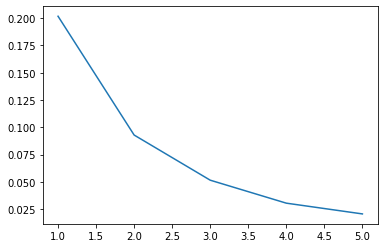

In [ ]:
#print(trainer.train_loss)
plt.plot([1,2,3,4,5], trainer.train_loss, label='Training Loss')
#plt.plot([1,2,3,4,5], trainer.eval_loss, label='Validation Loss')

In [ ]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)
predictions = pd.DataFrame()
predictions = predictions.append(classifier(encoded_dataset["test"]["sentence"]))

Disabling tokenizer parallelism, we're using DataLoader multithreading already


In [ ]:
from transformers.models.transfo_xl.tokenization_transfo_xl import Counter
Counter(dataset["train"]["label"])

Counter({0: 29780, 1: 37569})

In [ ]:
text = "This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."
text2 = "It was ok. I was expecting more."
text3 = "I hated it."
text4 = "Not my favorite, but I can see how others would enjoy it."

In [ ]:
#classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)
fine_tuned_results = pd.DataFrame()
fine_tuned_results = fine_tuned_results.append(classifier(text))
fine_tuned_results = fine_tuned_results.append(classifier(text2))
fine_tuned_results = fine_tuned_results.append(classifier(text3))
fine_tuned_results = fine_tuned_results.append(classifier(text4))
fine_tuned_results

,label,score
0,LABEL_1,0.978859
0,LABEL_1,0.998008
0,LABEL_0,0.999757
0,LABEL_1,0.974712


In [ ]:
#classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)
incorrect_predictions = pd.DataFrame()
count = 10

for eval in dataset['validation']:
    pred = classifier(eval['sentence'])

    if pred[0]['label'] == 'LABEL_1':
        pred[0]['label'] = 1
    else:
        pred[0]['label'] = 0

    if pred[0]['label'] != eval['label']:
        count -= 1
        incorrect_predictions = incorrect_predictions.append(eval, pred)

    if count == 0:
        break
incorrect_predictions

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,sentence,label,idx
0,you do n't have to know about music to appreci...,1.0,8.0
1,"we root for ( clara and paul ) , even like the...",1.0,13.0
2,holden caulfield did it better .,0.0,22.0
3,the primitive force of this film seems to bubb...,1.0,62.0
4,"the script kicks in , and mr. hartley 's diste...",0.0,64.0
5,"if you 're hard up for raunchy college humor ,...",1.0,66.0
6,though it 's become almost redundant to say so...,1.0,83.0
7,jaglom ... put ( s ) the audience in the privi...,1.0,87.0
8,"you wo n't like roger , but you will quickly r...",0.0,92.0
9,if steven soderbergh 's ` solaris ' is a failu...,1.0,93.0


In [ ]:
vanilla_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)
classifier = pipeline("sentiment-analysis", model=vanilla_model, tokenizer=tokenizer, device=device)

vanilla_results = pd.DataFrame()
vanilla_results = vanilla_results.append(classifier(text))
vanilla_results = vanilla_results.append(classifier(text2))
vanilla_results = vanilla_results.append(classifier(text3))
vanilla_results = vanilla_results.append(classifier(text4))
vanilla_results

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when in

,label,score
0,LABEL_0,0.552042
0,LABEL_0,0.547045
0,LABEL_0,0.542658
0,LABEL_0,0.549190


In [ ]:
inputs = tokenizer(text, return_tensors="pt").to(device)

In [ ]:
with torch.no_grad():
    logits = model(**inputs).logits

In [ ]:
predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'LABEL_1'

<ipython-input-75-54d8689c0b94>:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, labels)


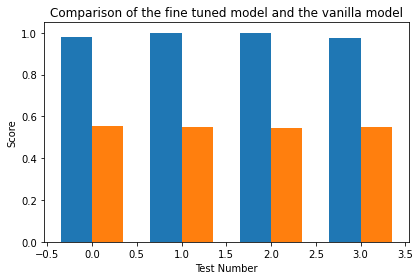

<Figure size 4000x3000 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

labels = ['1','2','3','4']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
rects1 = ax.bar(x - width/2, fine_tuned_results['score'], width, label='Fine Tuned')
rects2 = ax.bar(x + width/2, vanilla_results['score'], width, label='Vanilla')

# Adding labels and title
ax.set_xlabel("Test Number")
ax.set_ylabel("Score")
ax.set_title("Comparison of the fine tuned model and the vanilla model")
ax.set_xticks(x, labels)
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
plt.figure(figsize=[20,15], dpi=200)
fig.tight_layout()
# Show plot
plt.show()

In [ ]:
!nvidia-smi

Tue Feb 14 06:28:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |   2360MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------